In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [3]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [4]:
train = train[~((train['type']=='PM2.5')&(train['门头沟']>2000))]

In [5]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [6]:
train = preprocess(train)
test = preprocess(test)

In [478]:
def process_one_location(df, location, take_log=True, take_diff=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    subset_augmented = subset.asfreq('h')
#     subset_augmented = subset_augmented.interpolate(method = 'linear')

#     subset_augmented = subset_augmented.dropna()
    
#     if take_log:
#         subset_augmented = subset_augmented.apply(lambda x: np.log(x))
    if take_log:
        subset_augmented['PM2.5'] = subset_augmented['PM2.5'].map(lambda x: np.log(x))
        
    subset_augmented = feature_engineering(subset_augmented,n_lag,take_diff)
    
#     subset_augmented =  subset_augmented.dropna()
    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    
    if take_diff:
        subset_augmented['target'] = subset_augmented['PM2.5_diff']
        subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    else:
        subset_augmented['target'] = subset_augmented['PM2.5']
        subset_augmented = subset_augmented.drop(columns=['PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag, take_diff=True):
    if take_diff:
        subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
        subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
        subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
#         subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
        subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
#         subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
        subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
#         subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
        subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
#         subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented,take_diff)
    
    subset_augmented = calculate_rolling_stat(subset_augmented,take_diff)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
    
    #additional lags for PM2.5  
    for lag in range(n_lag+1,24):
        tmp = pd.DataFrame(subset_augmented[col[0]].shift(lag))
        tmp.columns = [f'{col[0]}_lag_{lag}']
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for p in col:
        res[f'{p}_daily_mean'] = res[p].rolling(24,min_periods=1).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24,min_periods=1).median()
        res[f'{p}_daily_std'] = res[p].rolling(24,min_periods=1).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7,min_periods=1).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7,min_periods=1).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7,min_periods=1).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30,min_periods=1).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30,min_periods=1).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30,min_periods=1).std()
    return res

In [479]:
IS_TAKING_LOG=False
IS_TAKING_DIFF=True

In [357]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

In [358]:
#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

In [359]:
if IS_TAKING_DIFF:
    alldata = alldata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    alldata = alldata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

if IS_TAKING_DIFF:
    allTestdata = allTestdata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    allTestdata = allTestdata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

In [361]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import minmax_scale

In [362]:
N_NEIGHBORS_MAX = 15

class Neighbors:
    def __init__(self, 
                 pivot: pd.DataFrame, 
                 name: str,
                 p: float, 
                 metric: str = 'minkowski', 
                 exclude_self: bool = False):
        self.exclude_self = exclude_self
        self.p = p
        self.metric = metric
        self.name=name
        
        if metric == 'random':
            n_queries = len(pivot)
            self.neighbors = np.random.randint(n_queries, size=(n_queries, N_NEIGHBORS_MAX))
        else:
            nn = NearestNeighbors(
                n_neighbors=N_NEIGHBORS_MAX, 
                p=p, 
                metric=metric, 
            )
            nn.fit(pivot)
            _, self.neighbors = nn.kneighbors(pivot, return_distance=True)

        self.columns = self.index = self.feature_values = self.feature_col = None

    def rearrange_feature_values(self, df: pd.DataFrame, feature_col: str):
        feature_pivot = df.pivot(columns='location',values=feature_col)
#         feature_pivot = feature_pivot.fillna(feature_pivot.mean())

        feature_values = np.zeros((N_NEIGHBORS_MAX, *feature_pivot.shape))

        for i in range(N_NEIGHBORS_MAX):
            feature_values[i, :, :] += feature_pivot.values[:, self.neighbors[:, i]]

        self.columns = list(feature_pivot.columns)
        self.index = list(feature_pivot.index)
        self.feature_values = feature_values
        self.feature_col = feature_col

    def make_nn_feature(self, n=5, agg=np.mean):
  
        start = 1 if self.exclude_self else 0

        pivot_aggs = pd.DataFrame(
            agg(self.feature_values[start:n,:,:], axis=0), 
            columns=self.columns, 
            index=self.index
        )

        dst = pivot_aggs.unstack().reset_index(0)
        
        dst.columns = ['location',  f'{self.feature_col}_nn{n}_{self.name}_{agg.__name__}']
        return dst


In [363]:
# alldata[['PM2.5_diff_daily_std','location']].pivot(columns='location')

In [364]:
location_neighbors = []

pivot = allTarget[["PM2.5","location"]].pivot(columns='location')
pivot = pivot.ffill().bfill()
# pivot = pd.DataFrame(minmax_scale(pivot))

location_neighbors.append(Neighbors(
            pivot.transpose(), 
            name='level',
            p = 1, 
            metric = 'minkowski',
            exclude_self = True
))

pivot = alldata[['PM2.5_diff_daily_std','location']].pivot(columns='location')
pivot = pivot.ffill().bfill()

location_neighbors.append(Neighbors(
            pivot.transpose(), 
            name='vol',
            p = 1, 
            metric = 'minkowski',
            exclude_self = True
))

In [369]:
def make_nn_features(df,nn,feature_col,locations,top_n=5,agg=np.mean):
    res = pd.DataFrame()
    for p in feature_col:
        nn.rearrange_feature_values(df,p)
        tmp = nn.make_nn_feature(top_n, agg)
        if res.empty:
            res = tmp
        else:
            col = tmp.columns[-1]
            res[col] = tmp[col]
    newDF = pd.DataFrame()
    for l in locations:
        tmp = pd.merge(res[res['location']==l].drop(columns=['location']),df[df['location']==l],left_index=True, right_index=True)
        newDF = pd.concat([newDF,tmp])
    del res, tmp
    gc.collect()
    return newDF

In [370]:
cols = alldata.columns[:-2]
cols = [ c for c in cols if 'PM' in c]

In [371]:
for nn in location_neighbors:
    for n in [3,5,10,15]: #number of neighbors
        alldata = make_nn_features(alldata,nn,cols,train.columns[1:],n)
        allTestdata = make_nn_features(allTestdata,nn,cols,train.columns[1:],n)

In [372]:
alldata = alldata[alldata.index>'2014-04-03']   #starting from April 3rd for complete data
allTarget = allTarget[allTarget.index>'2014-04-03']   #starting from April 3rd for complete data

In [373]:
allTestdata = allTestdata[allTestdata.index>='2017-01-01']
allTestTarget = allTestTarget[allTestTarget.index>='2017-01-01']

In [374]:
def filter_na(data,true_y,locations):
    res = pd.DataFrame()
    res_test = pd.DataFrame()
    for l in locations:
        subset = data[data['location']==l]
        testing_y = true_y[true_y['location']==l]
        train_notna_index = subset['target'].notna()
        subset = subset[train_notna_index]
        testing_y = testing_y[train_notna_index]
        
        res = pd.concat([res,subset])
        res_test = pd.concat([res_test,testing_y])
    return res, res_test

In [375]:
alldata_noNA, allTarget_noNA = filter_na(alldata,allTarget,train.columns[1:])

allTestdata_noNA, allTestTarget_noNA = filter_na(allTestdata,allTestTarget,train.columns[1:])

alldata_noNA['location'] = alldata_noNA['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noNA['location'].cat.categories ) )
alldata_noNA['location'] = alldata_noNA['location'].cat.codes
allTestdata_noNA['location'] = allTestdata_noNA['location'].astype('category')
allTestdata_noNA['location'] = allTestdata_noNA['location'].cat.codes

In [378]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [379]:
import lightgbm as lgb
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [380]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits
        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [381]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noNA,allTestdata_noNA,alldata_noNA['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 12.6675	valid_1's rmse: 14.6801
Early stopping, best iteration is:
[588]	training's rmse: 12.3515	valid_1's rmse: 14.6504
val rmse score is 14.650439601949213
Fold: 2
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.6846	valid_1's rmse: 19.246
[1000]	training's rmse: 10.4429	valid_1's rmse: 19.0505
Early stopping, best iteration is:
[1243]	training's rmse: 10.0164	valid_1's rmse: 19.0054
val rmse score is 19.005354382702716
Fold: 3
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[415]	training's rmse: 13.3654	valid_1's rmse: 12.6818
val rmse score is 12.681792116636785
Fold: 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[444]	training's rmse: 12.1231	valid_1's rmse: 18.9212
val rmse score is 18.92117459807399
Fold: 5
Training until validation scores don't impr

In [382]:
def process_prediction(predicted, true_y, take_log=True, take_diff=True):
    true_y['predicted'] = predicted
    if take_diff:
        true_y['prediction'] = true_y['predicted'] + true_y['PM2.5_y']
    else:
        true_y['prediction'] = true_y['predicted']
        
    true_y['prediction'] = true_y['prediction'].map(lambda x: max(x,0)) # floor at 0
    true_y['prediction'] = true_y['prediction'].map(lambda x: min(x,1000)) # cap at 1000
    
    if take_log:
        true_y['prediction']=true_y['prediction'].map(lambda x: np.exp(x))
        true_y['PM2.5_y']=true_y['PM2.5_y'].map(lambda x: np.exp(x))
        true_y['PM2.5']=true_y['PM2.5'].map(lambda x: np.exp(x))

    true_y.dropna(inplace=True)

In [383]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

Text(0.5, 1.0, '20 TOP feature importance over 5 folds average')

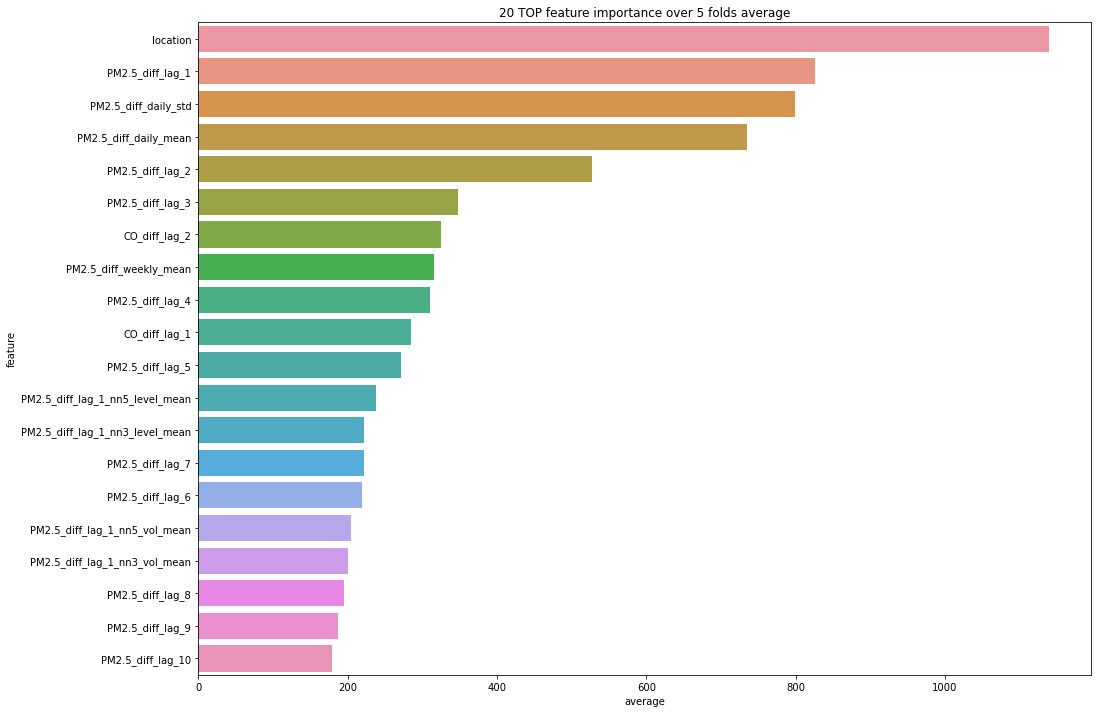

In [386]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
plt.title('20 TOP feature importance over {} folds average'.format(n_splits))

In [387]:
print('Out of sample RMSE for each location is')
display(allTestTarget_noNA.groupby(allTestTarget_noNA.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    22.591584
万柳      15.182796
东四      18.472900
东四环     16.054971
东高村     18.562287
丰台花园    16.727764
云岗      18.640796
亦庄      15.442478
八达岭     11.145060
农展馆     16.042938
前门      21.547270
北部新区    16.961401
南三环     23.435446
古城      19.814585
大兴      17.856773
天坛      16.352340
奥体中心    16.348687
官园      16.624447
定陵      13.458436
密云      14.474514
密云水库    11.797556
平谷      21.754887
延庆      16.860714
怀柔      16.338763
房山      18.885320
昌平      16.835974
植物园     15.387120
榆垡      26.815653
永乐店     20.052478
永定门内    23.796374
琉璃河     24.968257
西直门北    20.011774
通州      20.006014
门头沟     21.364122
顺义      16.274678
dtype: float64

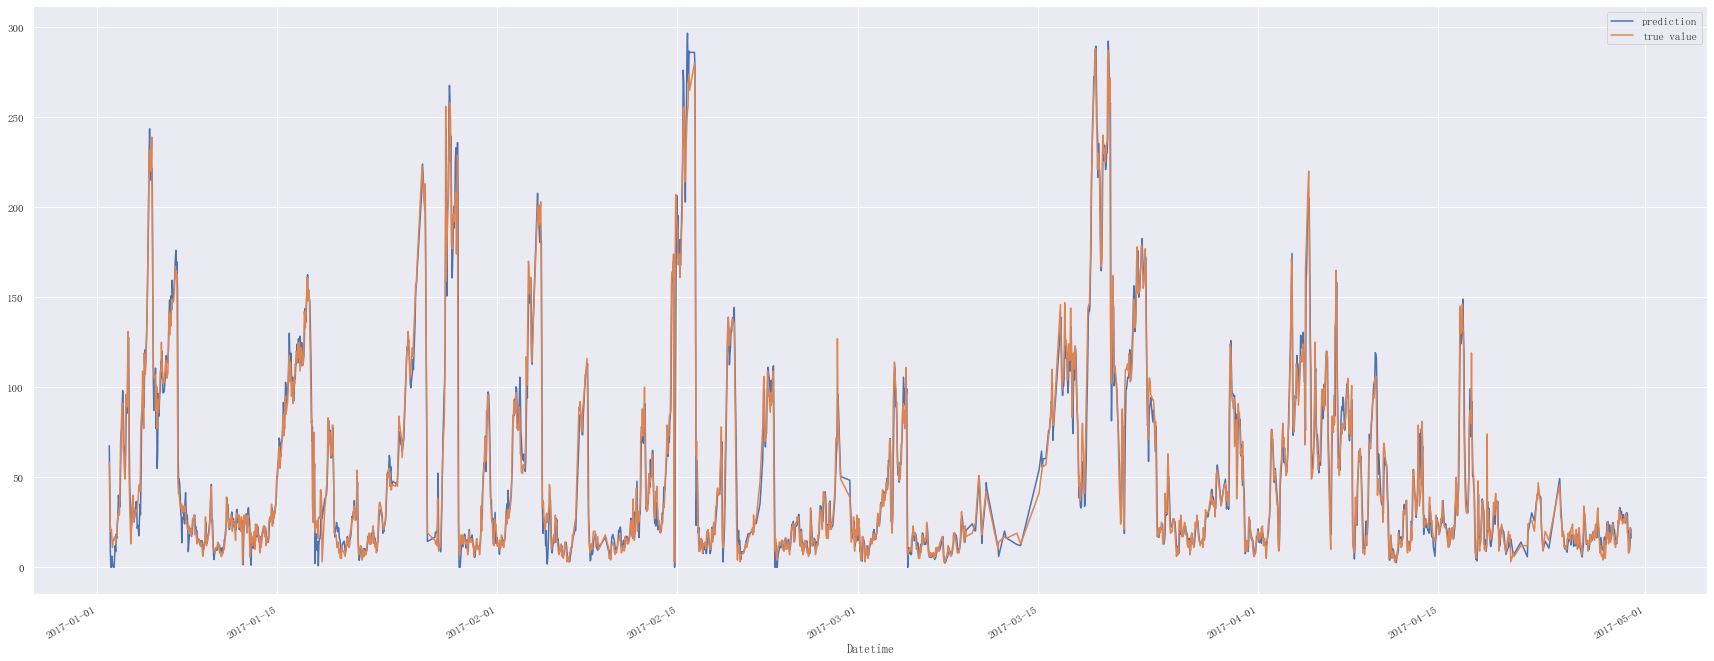

In [471]:
plt.figure(figsize=(30, 12))
allTestTarget_noNA[allTestTarget_noNA['location']=='八达岭']['prediction'].plot(label='prediction')
allTestTarget_noNA[allTestTarget_noNA['location']=='八达岭']['PM2.5'].plot(label='true value')
plt.legend()
plt.show()

In [393]:
final_results = {}

In [394]:
final_results['gbdt_cluster'] = (allTarget_noNA.copy(),allTestTarget_noNA.copy())

In [480]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])
if IS_TAKING_DIFF:
    alldata = alldata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    alldata = alldata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

if IS_TAKING_DIFF:
    allTestdata = allTestdata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    allTestdata = allTestdata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

<AxesSubplot:xlabel='None-location', ylabel='None-location'>

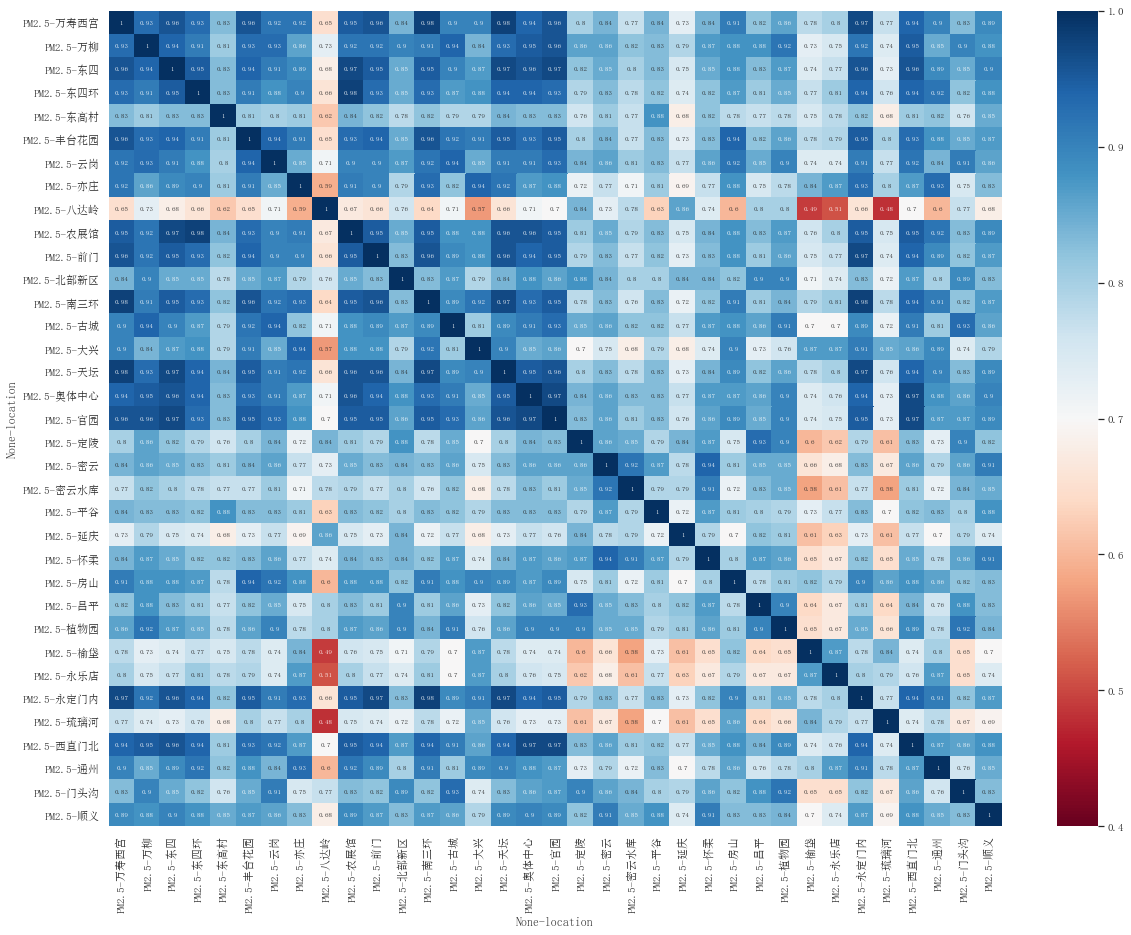

In [481]:
corr_data = allTarget[["PM2.5","location"]].pivot(columns='location')
corr = allTarget[["PM2.5","location"]].pivot(columns='location').corr()
plt.figure(figsize=(20,15))
sns.set(font="SimSun")
sns.heatmap(round(corr,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1)

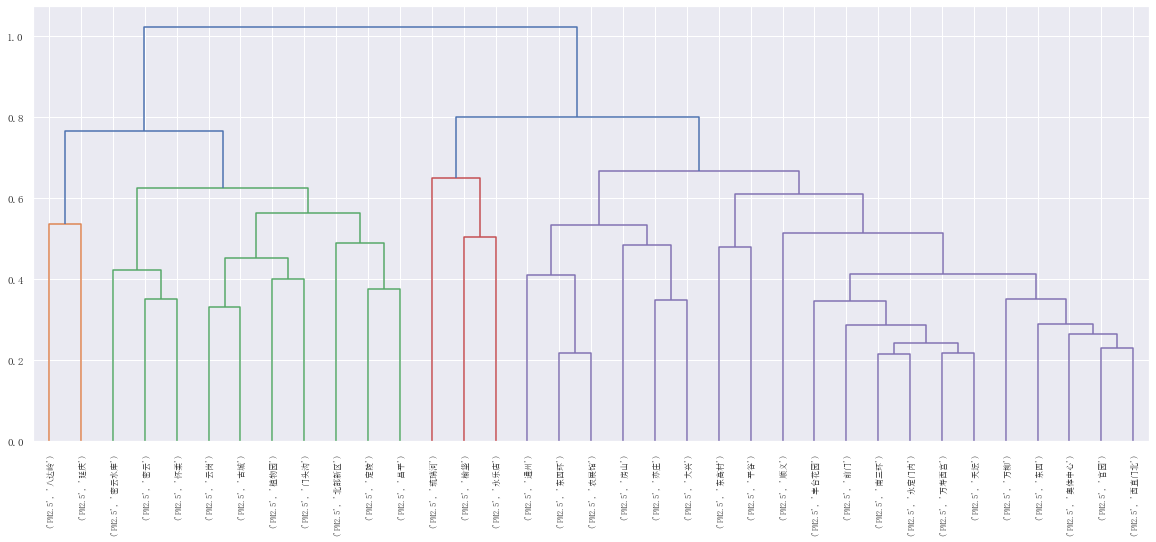

In [482]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
plt.figure(figsize=(20,8))
sns.set(font="SimSun",font_scale=1)
dissimilarity = np.sqrt(2*(1 - corr))
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=corr_data.columns, orientation='top', 
           leaf_rotation=90);

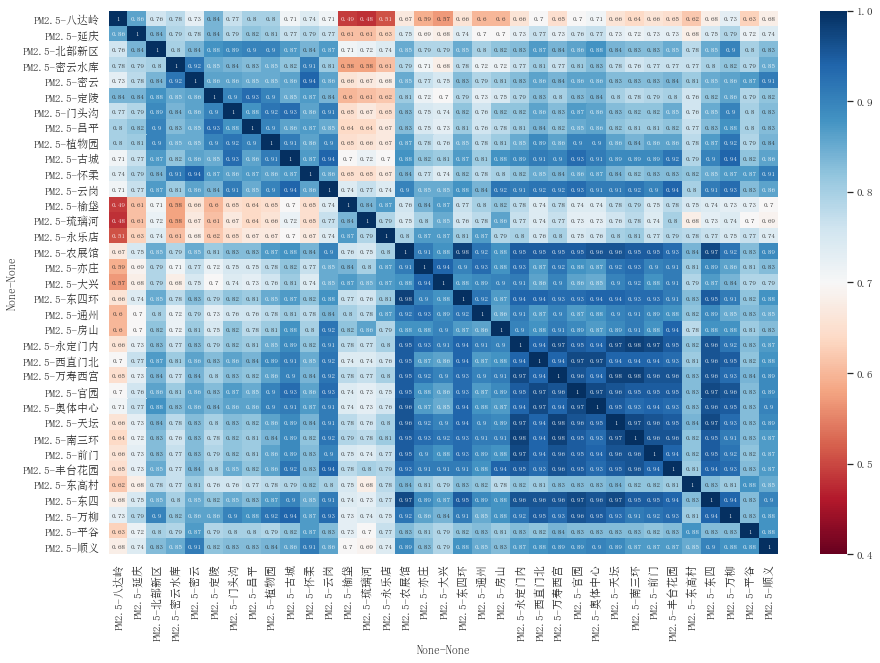

In [483]:
labels = fcluster(Z, t=5, criterion='maxclust')

labels_order = np.argsort(labels)

for idx, i in enumerate(corr_data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(corr_data[i])
    else:
        df_to_append = pd.DataFrame(corr_data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,10))
sns.set(font="SimSun",font_scale=1)
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1);

In [484]:
label_map = {c[1]:labels[i] for i,c in enumerate(corr_data.columns)}
def get_cluster_stats(labels,data):
    data = data.copy(deep=True)
    data['cluster'] = data['location'].map(lambda x: labels[x])
#     c.groupby('b').agg({'a': lambda x: x.mean(skipna=False)})
    tmp = data.groupby([data.index,'cluster'],as_index=False).mean()
    tmp = tmp.set_index(data.groupby([data.index,'cluster']).mean().index.get_level_values(0))
    newdf = pd.DataFrame()
    for c in set(tmp.cluster):
        cluster = tmp[tmp['cluster']==c]
        cluster.columns = [f'{col}_c{c}' for col in tmp.columns]
        newdf = pd.concat([newdf, cluster],axis=1)
    newdf = newdf[[col for col in newdf.columns if 'PM' in col]]
    newdf = pd.merge(newdf,data,left_index=True,right_index=True)
    newdf.drop(columns=['cluster'],inplace=True)
    del tmp
    gc.collect()
    return newdf

In [485]:
alldata = get_cluster_stats(label_map,alldata)
allTestdata = get_cluster_stats(label_map,allTestdata)

In [486]:
alldata = alldata[alldata.index>'2014-04-03']   #starting from April 3rd for complete data
allTarget = allTarget[allTarget.index>'2014-04-03']   #starting from April 3rd for complete data

In [487]:
alldata_noNA, allTarget_noNA = filter_na(alldata,allTarget,train.columns[1:])

In [488]:
allTestdata = allTestdata[allTestdata.index>='2017-01-01']
allTestTarget = allTestTarget[allTestTarget.index>='2017-01-01']

In [489]:
allTestdata_noNA, allTestTarget_noNA = filter_na(allTestdata,allTestTarget,train.columns[1:])

In [490]:
alldata_noNA['location'] = alldata_noNA['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noNA['location'].cat.categories ) )
alldata_noNA['location'] = alldata_noNA['location'].cat.codes
allTestdata_noNA['location'] = allTestdata_noNA['location'].astype('category')
allTestdata_noNA['location'] = allTestdata_noNA['location'].cat.codes

In [491]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noNA,allTestdata_noNA,alldata_noNA['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.6154	valid_1's rmse: 13.3116
[1000]	training's rmse: 9.44362	valid_1's rmse: 12.2243
[1500]	training's rmse: 7.98257	valid_1's rmse: 11.4752
[2000]	training's rmse: 6.90502	valid_1's rmse: 10.9256
[2500]	training's rmse: 6.06207	valid_1's rmse: 10.5079
[3000]	training's rmse: 5.39079	valid_1's rmse: 10.1831
[3500]	training's rmse: 4.84244	valid_1's rmse: 9.92977
[4000]	training's rmse: 4.39028	valid_1's rmse: 9.73681
[4500]	training's rmse: 4.00882	valid_1's rmse: 9.57829
[5000]	training's rmse: 3.68374	valid_1's rmse: 9.44254
[5500]	training's rmse: 3.40521	valid_1's rmse: 9.34225
[6000]	training's rmse: 3.16173	valid_1's rmse: 9.25087
[6500]	training's rmse: 2.94934	valid_1's rmse: 9.17854
[7000]	training's rmse: 2.76189	valid_1's rmse: 9.11976
[7500]	training's rmse: 2.59612	valid_1's rmse: 9.07194
[8000]	training's rmse: 2.44881	valid_1's rmse: 9.02943
[8500]	training's rmse: 2.31638	vali

In [494]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 10.49159406667625
Out of sample RMSE for LightGBM method is 14.40940992679728
In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [495]:
print(f'In sample RMSE for LightGBM method is {r2_score(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for LightGBM method is {r2_score(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"])}')

print(f'In sample RMSE for Naive method is {r2_score(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"])}')
print(f'Out of sample RMSE for Naive method is {r2_score(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"])}')

In sample RMSE for LightGBM method is 0.983453093973252
Out of sample RMSE for LightGBM method is 0.973326023493873
In sample RMSE for Naive method is 0.9403621340239634
Out of sample RMSE for Naive method is 0.9417088005212829


In [496]:
print('Out of sample RMSE for each location is')
display(allTestTarget_noNA.groupby(allTestTarget_noNA.location).apply(
    lambda x: r2_score(x['PM2.5'], x['prediction'])))

Out of sample RMSE for each location is


location
万寿西宫    0.966715
万柳      0.981913
东四      0.972915
东四环     0.981541
东高村     0.975316
丰台花园    0.985002
云岗      0.975916
亦庄      0.989588
八达岭     0.988738
农展馆     0.987049
前门      0.965824
北部新区    0.979471
南三环     0.960075
古城      0.966991
大兴      0.982388
天坛      0.982497
奥体中心    0.977667
官园      0.976452
定陵      0.985073
密云      0.983379
密云水库    0.984500
平谷      0.963946
延庆      0.951460
怀柔      0.970255
房山      0.976803
昌平      0.974436
植物园     0.975603
榆垡      0.969463
永乐店     0.980346
永定门内    0.956287
琉璃河     0.968198
西直门北    0.958880
通州      0.973190
门头沟     0.962483
顺义      0.980489
dtype: float64

In [500]:
print('Out of sample RMSE for each location is')
display(allTestTarget_noNA.groupby(allTestTarget_noNA.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    18.030540
万柳      11.311113
东四      15.172019
东四环     12.411955
东高村     12.373953
丰台花园    12.128399
云岗      15.314723
亦庄       9.732358
八达岭      5.807136
农展馆     10.061750
前门      18.040302
北部新区    11.032868
南三环     19.767295
古城      16.899633
大兴      13.764486
天坛      11.762640
奥体中心    12.741398
官园      12.223461
定陵       8.016917
密云       8.977887
密云水库     7.516872
平谷      18.103589
延庆      13.091786
怀柔      11.774641
房山      16.185770
昌平      11.536298
植物园     11.576101
榆垡      20.555664
永乐店     14.430453
永定门内    20.591507
琉璃河     20.874084
西直门北    18.034880
通州      17.136029
门头沟     16.510250
顺义      12.345727
dtype: float64

Text(0.5, 1.0, '40 TOP feature importance over 5 folds average')

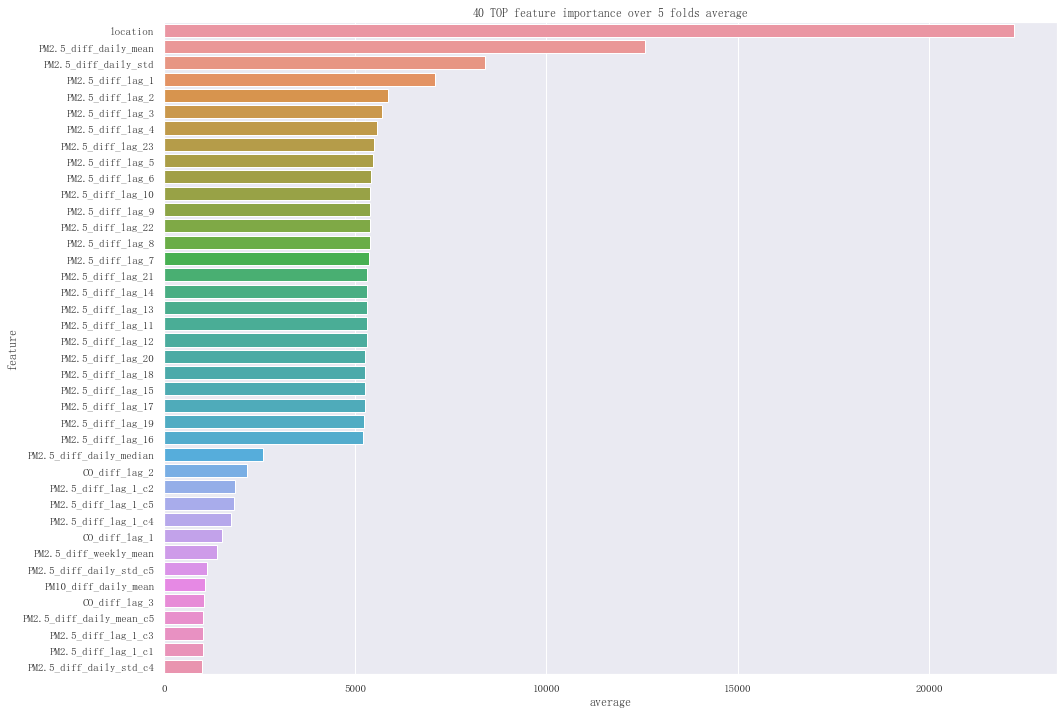

In [497]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(40), x='average', y='feature')
plt.title('40 TOP feature importance over {} folds average'.format(n_splits))

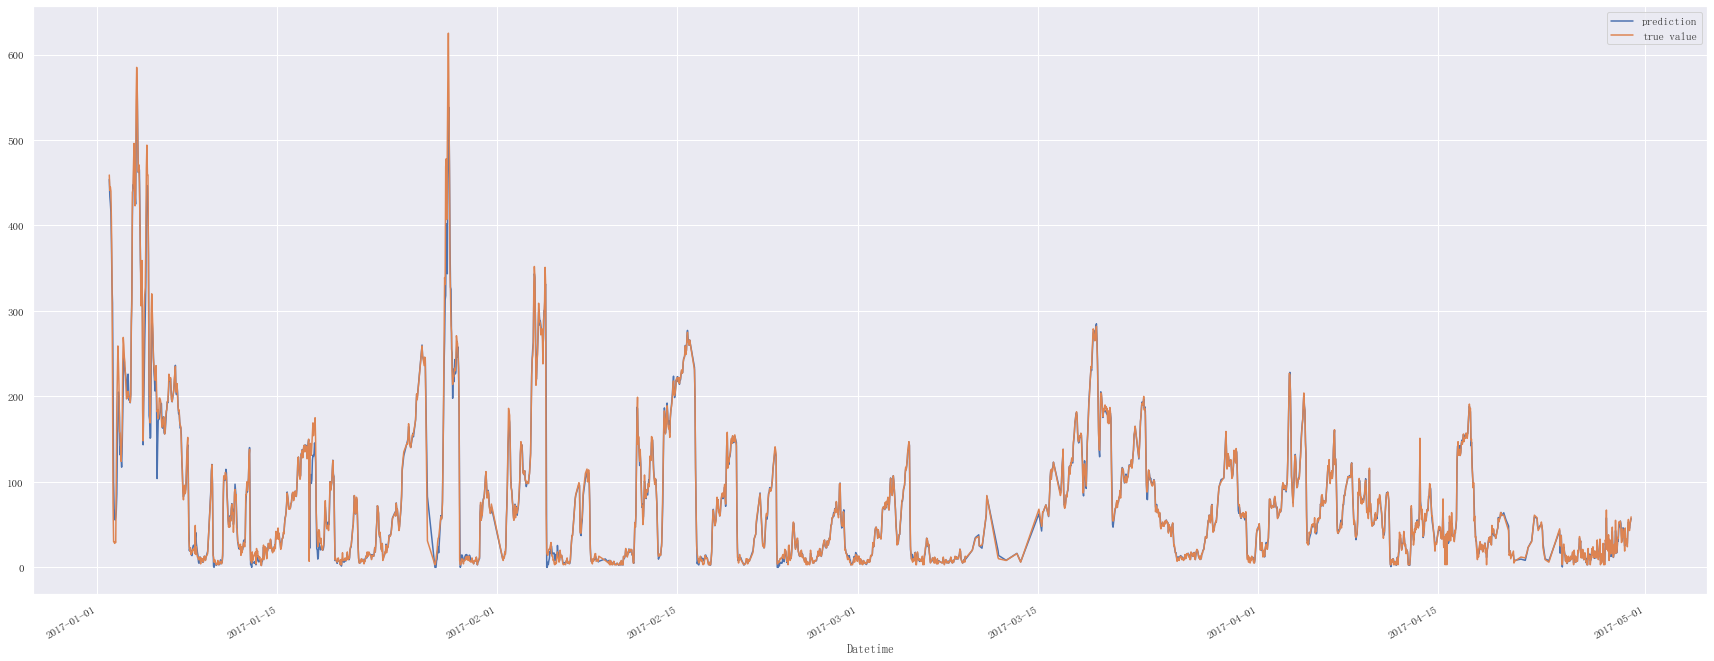

In [498]:
plt.figure(figsize=(30, 12))
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['prediction'].plot(label='prediction')
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['PM2.5'].plot(label='true value')
plt.legend()
plt.show()

In [499]:
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']

,PM2.5,location,PM2.5_y,predicted,prediction
Datetime,,,,,
2017-01-01 23:00:00,459.0,万柳,468.0,-14.090541,453.909459
2017-01-02 00:00:00,441.0,万柳,459.0,-25.072850,433.927150
2017-01-02 01:00:00,445.0,万柳,441.0,-14.907994,426.092006
2017-01-02 02:00:00,440.0,万柳,445.0,-29.342570,415.657430
2017-01-02 03:00:00,403.0,万柳,440.0,-59.583085,380.416915
...,...,...,...,...,...
2017-04-29 19:00:00,47.0,万柳,56.0,-7.105225,48.894775
2017-04-29 20:00:00,43.0,万柳,47.0,-1.530356,45.469644
2017-04-29 21:00:00,51.0,万柳,43.0,7.428799,50.428799


In [411]:
final_results['gbdt_knn'] = (allTarget_noNA.copy(),allTestTarget_noNA.copy())

In [465]:
w1 = 0.6
w2 = 1-w1

In [466]:
final_predictions = final_results['gbdt_knn'][0].prediction*w1 + final_results['gbdt_cluster'][0].prediction*w2

In [467]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(final_predictions,allTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 15.313512294886703


In [468]:
final_out_of_predictions = final_results['gbdt_knn'][1].prediction*w1 + final_results['gbdt_cluster'][1].prediction*w2

In [474]:
print(f'Out of sample RMSE for LightGBM method is {r2_score(final_out_of_predictions,allTestTarget_noNA["PM2.5"])}')

Out of sample RMSE for LightGBM method is 0.9586619076948574


In [502]:
alldata.columns

Index(['PM2.5_diff_lag_1_c1', 'PM2.5_diff_lag_2_c1', 'PM2.5_diff_lag_3_c1',
       'PM2.5_diff_lag_4_c1', 'PM2.5_diff_lag_5_c1', 'PM2.5_diff_lag_6_c1',
       'PM2.5_diff_lag_7_c1', 'PM2.5_diff_lag_8_c1', 'PM2.5_diff_lag_9_c1',
       'PM2.5_diff_lag_10_c1',
       ...
       'O3_diff_daily_median', 'O3_diff_daily_std', 'O3_diff_weekly_mean',
       'O3_diff_weekly_median', 'O3_diff_weekly_std', 'O3_diff_monthly_mean',
       'O3_diff_monthly_median', 'O3_diff_monthly_std', 'location', 'target'],
      dtype='object', length=296)